This notebook demonstrates how to use some of the classes and functions in RomPy's `algorithms` module. This module contains high-level functionality for implementing algorithms commonly used in reduced-order modeling and surrogate building, such as orthonormalization of a set of vectors, building an empirical interpolant from a given set of basis vectors, etc.

In [1]:
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

# Set font size for plotting
font = {'size':14}
plt.rc('font', **font)

# Import RomPy
import rompy as rp

## Orthonormalization with the iterated, modified Gram-Schmidt procedure

Here, we show how to build an orthonormal set of basis elements from a given set of vectors. The method uses the iterated, modified Gram-Schmidt procedure, which is a version of the Gram-Schmidt procedure that is robust to the accumulation of numerical round-off error from affecting the orthonormalization of a large number of vectors. The algorithm is described by Hoffman in "Iterative Algorithms for Gram-Schmidt Orthogonalization".

First, let's make some data to orthonormalize, which will just be a set of monomials.

In [2]:
x = np.linspace(-1, 1, num=1001)
vectors = [x**n for n in range(10)]

We'll need an integration rule since Gram-Schmidt requires an inner product to orthonormalize a set of vectors. We'll just use the trapezoidal rule since the monomials are evaluated at equally spaced points.

In [3]:
integration = rp.Integration([-1, 1], num=len(x), rule='trapezoidal')

Next, we make the basis by creating an instance of the `rp.algorithms.GramSchmidt` class. Then run `make` as follows:

In [4]:
gramschmidt = rp.algorithms.GramSchmidt(vectors, integration)
basis = gramschmidt.make()

We can check that the basis is orthonormal by computing dot products between the elements, which should give us either 1 or 0 (to within numerical round-off error).

In [5]:
for ii in range(len(basis)):
    print "Basis", ii+1, "dot products:\n  ", \
        [integration.real.dot(basis[ii], basis[jj]) for jj in range(ii, len(basis))]

Basis 1 dot products:
   [1.0000000000000004, 4.5536491244391186e-17, 5.4795577797417394e-16, -3.426078865054194e-17, -5.4426949058772323e-17, 1.3877787807814457e-17, -4.1199682554449168e-18, -9.1072982488782372e-18, 1.4311468676808659e-17, 3.2092384305570931e-17]
Basis 2 dot products:
   [1.0000000000000002, 4.90059381963448e-17, -8.4784609888366447e-16, -2.9490299091605721e-17, 6.0715321659188248e-18, 3.0357660829594124e-18, -1.2576745200831851e-17, -2.8622937353617317e-17, -4.3368086899420177e-18]
Basis 3 dot products:
   [1.0000000000000002, -4.3368086899420177e-19, 1.3010426069826053e-17, 1.7347234759768071e-18, -1.5612511283791264e-17, 3.4694469519536142e-18, 9.540979117872439e-18, 3.4694469519536142e-18]
Basis 4 dot products:
   [0.99999999999999989, 3.1225022567582528e-17, -8.6736173798840355e-19, -2.6020852139652106e-18, -2.6020852139652106e-18, 3.0357660829594124e-17, -6.0715321659188248e-18]
Basis 5 dot products:
   [1.0, -6.0715321659188248e-18, 2.2551405187698492e-17, -4.6

Not surprisingly, the basis returned is proportional to the set of Legendre polynomials, $\{P_\ell (x) \}$. The proportionality is given by $\sqrt{\ell+1/2}$, which is the integration weight that appears in Sturm-Liouville theory. Below is a plot of the basis elements (gray) and the fourth Legendre polynomial, $P_4(x)$, in dashed red for comparison. Note that $P_4(x)$ overlays the curve for the fourth basis element.

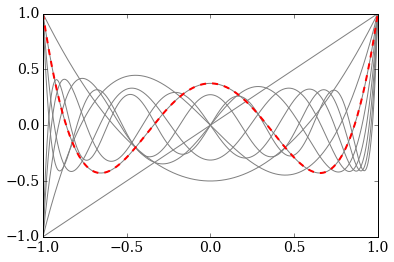

In [6]:
# Plot basis elements divided by sqrt(l+1/2)
[plt.plot(x, basis[ell]/np.sqrt(ell+1./2.), '-', color='gray') for ell in range(len(basis))];

# Plot the fourth Legendre polynomial
from numpy.polynomial.legendre import legval
plt.plot(x, legval(x,[0,0,0,0,1,0,0,0,0,0]), 'r--', linewidth=2);

The elements of the fourth basis (divided by sqrt(l+1/2)) and the fourth Legendre polynomial is given below for comparison. The errors are due to the error incurred in the numerical integrations involved with generating the basis. Increasing the number of points in the array `x` will give a more accurate comparison.

In [7]:
# Print the fourth basis element (divided by sqrt(l+1/2)) and the fourth Legendre polynomial
print basis[4]/np.sqrt(4.+0.5)
print legval(x,[0,0,0,0,1,0,0,0,0,0])

[ 0.999945    0.98003559  0.96030533 ...,  0.96030533  0.98003559  0.999945  ]
[ 1.          0.98008986  0.96035888 ...,  0.96035888  0.98008986  1.        ]


## Build a reduced basis

In this example, we'll show how to build a reduced basis for Bessel's function of the first kind, $J_\nu(x)$. We first define our training set to be parametrized by $\nu \in [0, 100]$ with $1001$ equally spaced points.

In [2]:
nu = np.linspace(0, 100, 1001)

We will take the set of Bessel's functions for each of these values of $\nu$ to be for $x \in [0, 1000]$ with $10,\!001$ equally-spaced samples to constitute the training space of functions. We take the trapezoidal rule for our integration scheme. Of course, other choices can be made in all regards here and the user is encouraged to explore the available options.

In [3]:
from scipy.special import jv as BesselJ

# Make integration rule
integration = rp.Integration([0, 1000], num=10001, rule='trapezoidal')
x = integration.nodes

# NOTE: Generating the training space may take a few minutes
training = np.array([BesselJ(nn, x) for nn in nu])

We can build a reduced basis representation that spans the arrays in the training space by making an instance of the `algorithms.ReducedBasis` class. This class allocates memory to the arrays the greedy algorithm needs for building the reduced basis. The default options for the `ReducedBasis` class is to make a reduced basis by selecting the most distinct (and thus relevant) values of $\nu$ according to the $L_2$ norm of the difference between the training space functions and their projection onto the current basis elements. See the code documentation for further information.

In [4]:
rb = rp.algorithms.ReducedBasis(integration)

To make the reduced basis just use the `make` method. The first argument is the training space that one is finding the reduced basis for. The second argument is the index of the seed value for $\nu$ that starts the greedy algorithm. The third argument is the error tolerance that terminates the greedy algorithm.

In [5]:
rb.make(training, 0, 1e-14, verbose=True, rel=False)


Step 	Error
1 	3.04450524606
2 	2.37058759372
3 	1.45091751656
4 	1.35950603369
5 	1.27385219212
6 	1.21241474394
7 	1.18188719894
8 	1.15470522576
9 	1.10979975123
10 	1.08038358704
11 	1.06531164434
12 	1.06058803423
13 	1.03703633161
14 	1.03072192056
15 	1.02502219628
16 	1.02298606303
17 	0.996943477798
18 	0.967838663388
19 	0.957886628775
20 	0.946445061289
21 	0.938825677533
22 	0.919508508122
23 	0.917053839332
24 	0.891227400452
25 	0.867743704259
26 	0.85821950917
27 	0.857213025298
28 	0.852863881692
29 	0.847493022891
30 	0.812016762609
31 	0.809983139189
32 	0.807364556415
33 	0.805350581404
34 	0.797895122779
35 	0.797188955992
36 	0.787718593549
37 	0.778217423722
38 	0.77522321278
39 	0.770721743985
40 	0.761873112956
41 	0.7451184932
42 	0.742239512418
43 	0.738604265602
44 	0.737713596528
45 	0.715293708056
46 	0.713626902551
47 	0.713141070993
48 	0.710622816777
49 	0.710267371447
50 	0.704842493737
51 	0.661302142811
52 	0.115060960932
53 	0.0841433401189
54 	0.03

In [6]:
rb.size

74

The $L_2$ norms of the maximum difference between the training space data and its projection onto the current basis, often called the "greedy error" or "representation error", is given below. Note the exponential convergence in the size of the basis after a plateau. This exponential convergence is typical (and expected) of training data with an underlying dependence that is smooth on the parameter (i.e., $\nu$).

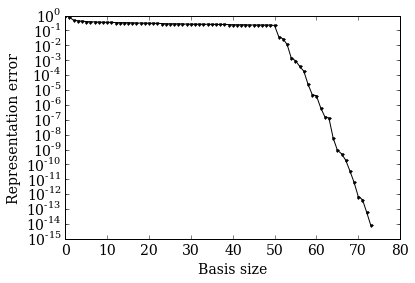

In [7]:
plt.semilogy(rb.errors/rb.errors[0], 'k.-');
plt.xlabel('Basis size')
plt.ylabel('Representation error')
plt.show()

After running the greedy algorithm, all the information in the training space is represented by $73$ reduced basis elements to within an error of a few parts in $10^{-14}$. This gives a compression of the training space by a factor of $1001/73 \approx 13.7$.

Here's how the $50^{\rm th}$ reduced basis element looks as a function of $x$.

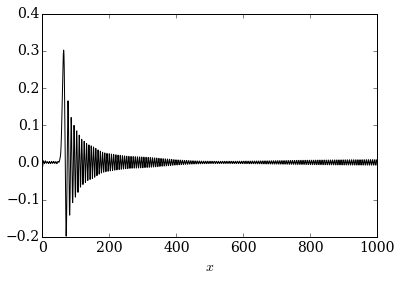

In [8]:
plt.plot(x, rb.basis[50], 'k-')
plt.xlabel('$x$');
plt.show()

The values of $\nu$ selected by the greedy algorithm are shown as a histogram below. Notice that more values tend to be selected near the edges of the training set domain.

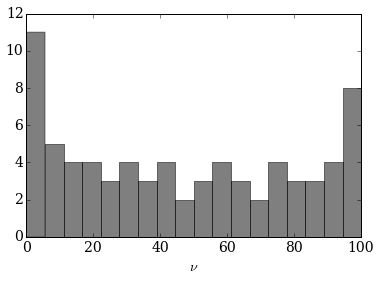

In [9]:
plt.hist(nu[rb.indices], rb.errors.size/4., color='k', alpha=0.5)
plt.xlabel('$\\nu$');
plt.xlim(0, 100);
plt.show()

To gain some intuition about what the greedy algorithm is doing, it is useful to show the complex norm-squared of the quantity $$\alpha_{ij} = \sum_{k=0}^i \langle e_k , J_{\nu_j} \rangle $$ where $i$ indexes the size of the reduced basis (i.e., the number of basis vectors) in the current iteration of the greedy algorithm while $j$ indexes the training space function. The inner product $\langle \cdot, \cdot \rangle$ is measured in the $L_2$ norm. We plot $| \alpha_{ij}|^2$ below. The values of $\nu$ in the training set that give a maximum for $|\alpha_{ij}|^2$ for a given $i$ are what is selected by the greedy algorithm for the next basis element to be included (upon orthonormalizing).

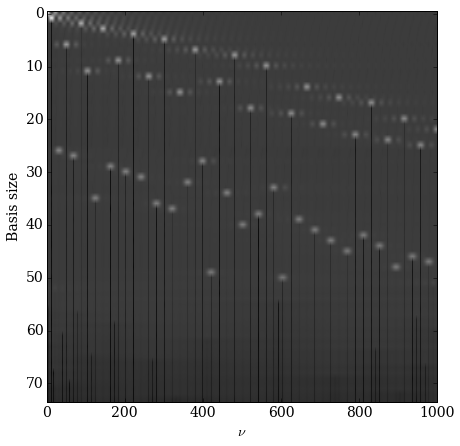

In [16]:
dim_alpha = np.shape(rb.alpha)
fig1 = plt.figure(1, [7,7])
ax1 = fig1.add_subplot(111)
ax1.imshow(np.abs(rb.alpha)**2, aspect=float(dim_alpha[1])/dim_alpha[0], cmap=plt.cm.Greys_r);
ax1.imshow(np.log10(np.abs(rb.alpha)**2), aspect=float(dim_alpha[1])/dim_alpha[0], cmap=plt.cm.Greys_r, alpha=0.25);
plt.xlabel('$\\nu$')
plt.ylabel('Basis size')
plt.show()

Note the dark lines below the white fuzzy dots (which are the maximum values of $|\alpha_{ij}|^2$. These are dark (i.e., very small, near zero) because the inner product of any training space data with the basis is, by construction, going to be near zero. This kind of plot also shows the order in which regions of the training set parameters are selected by the greedy algorithm. By the time $i=50$ comes around the greedy errors begin to decay exponentially with the basis size, which is why the white fuzzy dots seem to "disappear" in the plot. 

Lastly, `rb` contains a `project` method to compute the projection of a given array onto the reduced basis. Let's see how well the reduced basis represents a Bessel's function with $\nu=100$ versus $\nu=110$, outside of the training space, by computing the mismatch with the actual Bessel's function.

In [17]:
print "nu = 100:", integration.mismatch(BesselJ(100., x), rb.project(BesselJ(100., x)))
print "nu = 200:", integration.mismatch(BesselJ(110., x), rb.project(BesselJ(110., x)))

nu = 100: 1.44328993201e-15
nu = 200: 0.194976924236


## Build an empirical interpolant

The reduced basis for Bessel's function of the first kind, which is valid over the training set defined by $\nu \in [0, 100]$, can be interpreted as compressing the $\nu$ dependence of the training space data into a much smaller representation with a loss of accuracy up to numerical round-off errors, essentially, of double-precision floating point arithmetic. 

This data can be further compressed but in $x$ using the Empirical Interpolation method. Empirical interpolation finds the set of $x$ values that "optimally" represents the $x$-dependence of the reduced basis functions. The number of such values is, by construction, equal to the number of reduced elements (i.e., $74$). The resulting empirical interpolant provides a kind of "dual" compression in the $x$-direction that is afforded by the compression in $\nu$ via the reduced basis.

To build an empirical interpolant from the reduced basis we computed earlier for Bessel's function of the first kind we create an instance of the `algorithms.StandardEIM` class and run the `make` method where the reduced basis is the only input.

In [10]:
eim = rp.algorithms.EmpiricalInterpolant(rb.basis, verbose=True)


Step 	Nodes
1 	0
2 	20
3 	104
4 	162
5 	244
6 	324
7 	391
8 	423
9 	509
10 	203
11 	590
12 	475
13 	295
14 	537
15 	697
16 	669
17 	779
18 	864
19 	807
20 	1010
21 	933
22 	736
23 	1050
24 	838
25 	971
26 	1195
27 	47
28 	78
29 	354
30 	756
31 	269
32 	897
33 	1473
34 	633
35 	567
36 	137
37 	449
38 	2665
39 	1132
40 	1072
41 	1718
42 	1319
43 	1379
44 	2031
45 	1666
46 	3745
47 	2116
48 	1260
49 	5647
50 	9985
51 	4174
52 	2780
53 	5853
54 	2
55 	10000
56 	8
57 	183
58 	990
59 	3217
60 	1878
61 	1
62 	7702
63 	33
64 	8033
65 	63
66 	613
67 	1106
68 	4
69 	4541
70 	120
71 	12
72 	2330
73 	9054
74 	1531


Relative to the amount of data contained in the original training space, which is the number of $x$ samples times the number of $\nu$ samples, we find a total compression factor of almost $2,\!000$,

In [11]:
print float(x.size*nu.size)/(eim.size*rb.size)

1828.15942294


To use the empirical interpolant to "interpolate" (actually, to reconstruct) some training data just run the following for the first element, for example, in the training space, $\nu=0$:

In [12]:
eim.interpolate(training[0])

array([ 1.        ,  0.99750156,  0.99002497, ...,  0.02523203,
        0.02513492,  0.02478669])

The output of the empirical interpolation is accurate essentially to numerical round-off though some error is incurred

In [13]:
# Compute the max of the L-infinity residuals between the empirical 
# interpolation for each member of the training space.
eim_max_error = max([integration.Linfty(tt-eim.interpolate(tt)) for tt in training])
print eim_max_error

1.4007057018e-07


Performing empirical interpolation is independent of $\nu$, unlike for `scipy`'s implementation of Bessel's function, and is between about 10 and 100 times faster to evaluate than `scipy`'s implementation.

In [22]:
# Timings for nu = 0
%timeit BesselJ(nu[0], x)
%timeit eim.interpolate(training[0])

100 loops, best of 3: 5.48 ms per loop
1000 loops, best of 3: 495 µs per loop


In [23]:
# Timings for nu = 100
%timeit BesselJ(nu[-1], x)
%timeit eim.interpolate(training[-1])

10 loops, best of 3: 52.4 ms per loop
1000 loops, best of 3: 492 µs per loop


To wrap up this example, we show the values of $\nu$ selected by the reduced basis greedy algorithm with the corresponding values of $x$ that make up the empirical interpolation "nodes." The grid lines are meant to indicate the amount of training information needed to recover any training space data to within the max error of the empirical interpolation (i.e., $\approx 1.4 \times 10^{-7}$ here).

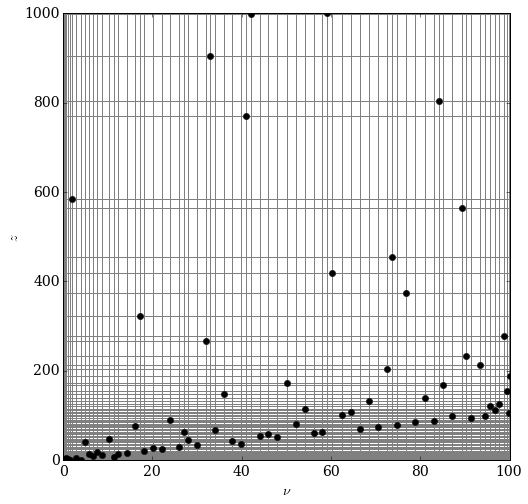

In [24]:
fig2 = plt.figure(2, [8,8])
ax2 = fig2.add_subplot(111)
[ax2.axvline(x=nn, color='gray') for nn in nu[rb.indices]]
[ax2.axhline(y=xx, color='gray') for xx in x[eim.indices]]
ax2.plot(nu[rb.indices], x[eim.indices], 'ko');
ax2.set_xlim(nu.min(), nu.max())
ax2.set_xlabel('$\\nu$');
ax2.set_ylabel('$z$');
plt.show()

Note that more information is needed for $x < 200$ than for $x > 200$ as suggested by the density of grid lines. However, the grid lines are somewhat constant as $\nu$ changes except near the edges of the training domain, as already found earlier when we built the reduced basis.

Also, if we were to fit for the $\nu$ variation at each of the empirical interpolation nodes than we would have what's called a "surrogate" model for Bessel's function of the first kind that can be evaluated as a substitute (hence, surrogate) for scipy's implementation for any $\nu \in [0, 100]$. This is useful when the time it takes for a code to generate some quantity of interest takes too long, which is determined by the application of interest.

## Build a surrogate

In our last example, we show how to build a surrogate model for the fast and accurate evaluation of Bessel functions given the reduced basis and empirical interpolation data we constructed above. In the first step, we gather all the (training space) data at the empirical interpolation nodes from which we will fit for the parameter variation at each node.

In [14]:
eim.make_data(training)

Here's a plot showing the Bessel function amplitudes in the training space at the 11th empirical node.

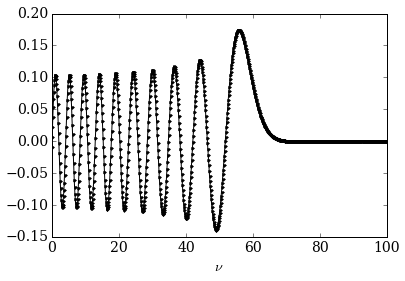

In [15]:
plt.plot(nu, eim.data[10], 'k.-')
plt.xlabel('$\\nu$');

As we can see from this plot, the data is dense for fitting purposes so we can interpolate using splines. Before building the actual surrogate, let's see what kinds of (univariate) fits are available in `RomPy`. The class `Univariate` is mostly a wrapper to `python` fitting routines but with a uniform way to interact with these functions. Results from the fit, such as fit coefficients and other information, can be accessed from the `_eval` attribute.

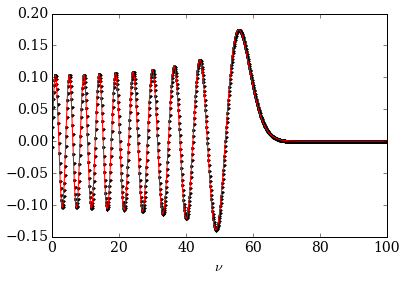

In [17]:
# Spline interpolant of the data at the 11th empirical node
fit = rp.UnivariateFits(nu, eim.data[10], fit='spline', s=0, deg=5)

plt.plot(nu, BesselJ(nu, x[eim.indices[10]]), 'k.')
plt.plot(nu, fit(nu), 'r-')
plt.xlabel('$\\nu$');

Let's compare the time it takes to evaluate the `BesselJ` function to the time it takes to evaluate the fits made above.

In [21]:
%timeit BesselJ(nu, x[eim.indices[10]])
%timeit fit(nu)

100 loops, best of 3: 2.82 ms per loop
10000 loops, best of 3: 150 µs per loop


Now that we know how to build a reduced basis, how to construct an empirical interpolant, and how to fit for the parameter variation at the empirical nodes then we can put all these ingredients together to build a reduced-order surrogate model for the fast and accurate evaluation of the `BesselJ` function. 

The `Surrogate` class in `rompy.algorithms` uses the `make_rom` method to build a reduced-order model (i.e., a reduced basis and empirical interpolant) of the given training data. Since we've already built the basis and interpolant then we just need to give their respective instance methods as input to the `Surrogate` class. The `fits` method performs, in this case, a univariate non-smoothing spline fit to the data at each empirical time node. The surrogate model can be evaluated using the `eval` method or just calling the instance method directly.

In [18]:
sur = rp.algorithms.Surrogate(integration, rb=rb, ei=eim)
sur.make_fits(nu, fit='spline', s=0, deg=5)

The resulting reduced-order surrogate model can be evaluated at any $\nu$ in the training set range by calling:

In [19]:
Nu = 94.12
print sur.eval(Nu)
print sur(Nu)

[  4.10798002e-18  -5.45081814e-18  -2.57273756e-18 ...,   1.16654196e-02
   9.37694347e-03   6.99583896e-03]
[  4.10798002e-18  -5.45081814e-18  -2.57273756e-18 ...,   1.16654196e-02
   9.37694347e-03   6.99583896e-03]


By the eyeball norm the surrogate seems to reproduce the corresponding Bessel function accurately.

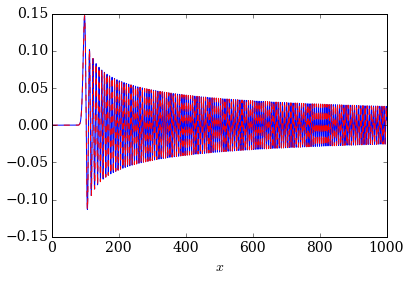

In [20]:
plt.plot(x, BesselJ(Nu, x), 'b-')
plt.plot(x, sur(Nu), 'r--')
plt.xlabel('$x$');

Evaluating the surrogate model is faster than calling the `BesselJ` function directly.

In [22]:
%timeit sur(Nu)
%timeit BesselJ(Nu, x)

100 loops, best of 3: 2.21 ms per loop
10 loops, best of 3: 54.6 ms per loop


Lastly, we plot the loss (here, the absolute difference) between the true values of the Bessel function and the surrogate's prediction.

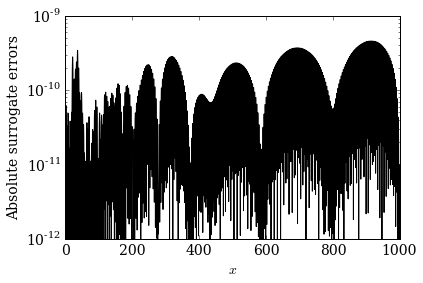

In [23]:
loss = np.abs(BesselJ(Nu, x)-sur(Nu))
plt.semilogy(x, loss, 'k-')
plt.ylabel('Absolute surrogate errors')
plt.xlabel('$x$')
plt.ylim(1e-12, 1e-9);

## Streamlined surrogate building with RomPy

To build a standard surrogate model from some training data, all we need to run are the basic commands below.

In [25]:
sur_L2 = rp.algorithms.Surrogate(integration)
sur_L2.make_rom(training, 0, 1e-12)  # Uses the L2 loss function for computing projection errors
print "Basis size =", sur.rb.size
sur_L2.make_fits(nu, fit='spline')  # Fit empirical node data to (default) 5th degree, non-smoothing splines (s=0)

Basis size = 74


Here's a different surrogate that uses the $L_\infty$ loss function to compute the errors between the training space data and their projections onto the basis. Note that this loss function chooses the reduced data based on the maximum point-wise difference between the training set and their projections, which is thus more stringent than the $L_2$ loss function since the latter is related to averaging the point-wise difference.

In [24]:
sur_Linfty = rp.algorithms.Surrogate(integration)
sur_Linfty.make_rom(training, 0, 1e-12, loss='Linfty')  # Uses the L-infinity loss function for computing projection errors
print "Basis size =", sur_Linfty.rb.size
sur_Linfty.make_fits(nu, fit='spline')  # Fit empirical node data to (default) 5th degree, non-smoothing splines (s=0)

Basis size = 86


For comparison, their projection errors as a function of the reduced basis size are below:

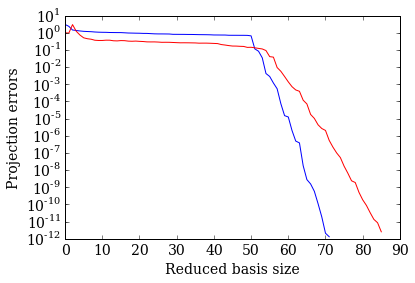

In [26]:
plt.semilogy(sur_L2.rb.errors, 'b-', sur_Linfty.rb.errors, 'r-')
plt.ylabel('Projection errors')
plt.xlabel('Reduced basis size');

We can test both surrogates by comparing their predictions at $\nu$ values not used for building the models. We see that the $L_2$-based surrogate generally does somewhat worse -- though still very accurate -- compared to the $L_\infty$-based model.

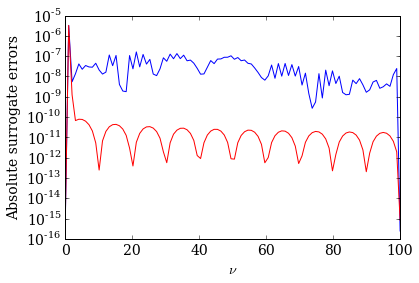

In [27]:
nus = np.linspace(nu.min(), nu.max(), 100)

plt.semilogy(nus, [integration.Linfty(BesselJ(nn, x)-sur_L2(nn)) for nn in nus], 'b-')
plt.semilogy(nus, [integration.Linfty(BesselJ(nn, x)-sur_Linfty(nn)) for nn in nus], 'r-')
plt.ylabel('Absolute surrogate errors')
plt.xlabel('$\\nu$');

However, notice that the Bessel function is predicted rather poorly for small values of $\nu$. What's going on? Inspection of the training data variation with $\nu$ at the first empirical node (which is at $t=0$) reveals that the data is non-zero only at $\nu=1$. 

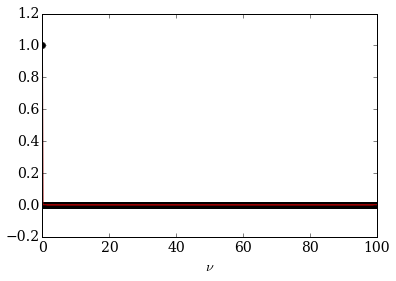

In [28]:
ind = 0
plt.plot(nu, sur_L2.ei.data[ind], 'ko-')
plt.plot(nu, sur_L2.fits._eval[ind](nu), 'r-')
plt.xlabel('$\\nu$');

This non-smooth feature will not be accurately captured by a spline interpolant. Since we know what the behavior should be we simply construct a function that is $1$ at the origin and $0$ elsewhere and use this to replace the first entry in the `sur_L2.fits._eval` and `sur_Linfty.fits._eval` lists.

In [29]:
def delta(x):
    return 1. * (x == 0)

sur_L2.fits._eval[0] = delta
sur_Linfty.fits._eval[0] = delta

Recomputing the errors above we find much better behavior for small $\nu$. 

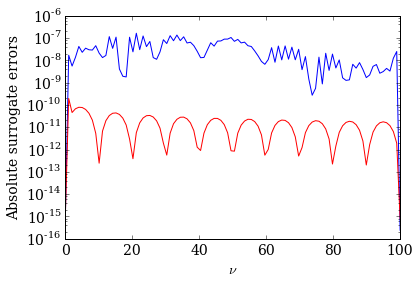

In [30]:
nus = np.linspace(nu.min(), nu.max(), 100)

plt.semilogy(nus, [integration.Linfty(BesselJ(nn, x)-sur_L2(nn)) for nn in nus], 'b-')
plt.semilogy(nus, [integration.Linfty(BesselJ(nn, x)-sur_Linfty(nn)) for nn in nus], 'r-')
plt.ylabel('Absolute surrogate errors')
plt.xlabel('$\\nu$');